In [33]:
#Libraries
import requests as rq
import numpy as np
import pandas as pd
import math

In [34]:
#using hopkins available CSV to get data rather than having to webscrape ourselves
URL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
covidData = pd.read_csv(URL)
#print(covidData)

In [35]:
#getting relevant data
covidData = covidData.drop(['Lat','Long'], axis=1)
#covidData = covidData.drop('Province/State', axis=1)
#print(covidData)

In [36]:
covidData = covidData.set_index('Country/Region', drop = True)
#print(covidData)

In [37]:
#data was originally by province/region this next thing sums it up
covidData = covidData.groupby('Country/Region').sum()

#print(covidData)

In [38]:
#omitting every country with less than 750 cases, as of May 3rd
droppedIndexes = covidData[covidData['5/3/20'] < 750].index
covidData.drop(droppedIndexes, inplace = True)

#manipulating data to make it easier to work with for later
covidData = covidData.T
covidData = covidData.reset_index()
covidData = covidData.drop('index', axis=1)

#print(covidData)

#note first date was 1/22/20

In [7]:
i=0
covidDaata=pd.DataFrame.to_numpy(covidData)
Standardized=np.zeros((10,187))
while i<187:
    a=covidDaata[:,i]
    j=0
    while j<102:
        b=a[j]
        if b==0:
            j+=1
        else:
            k=j+10
            if k<102:
                Standardized[:,i]=a[j:k]
            j=102
    i+=1
Standf=pd.DataFrame(data=Standardized)

#print(Standf)

In [8]:
#print(covidData.columns)

In [9]:
Standf = Standf.set_axis(covidData.columns, axis = 'columns')
print(Standf)

Country/Region  Afghanistan  Albania  Algeria  Andorra  Angola  \
0                       1.0      2.0      1.0      1.0     1.0   
1                       1.0     10.0      1.0      1.0     2.0   
2                       1.0     12.0      1.0      1.0     2.0   
3                       1.0     23.0      1.0      1.0     3.0   
4                       1.0     33.0      1.0      1.0     3.0   
5                       1.0     38.0      1.0      1.0     3.0   
6                       1.0     42.0      3.0      1.0     4.0   
7                       1.0     51.0      5.0      1.0     4.0   
8                       1.0     55.0     12.0      1.0     5.0   
9                       1.0     59.0     12.0      1.0     7.0   

Country/Region  Antigua and Barbuda  Argentina  Armenia  Australia  Austria  \
0                               1.0        1.0      1.0        4.0      2.0   
1                               1.0        1.0      1.0        5.0      2.0   
2                               1.0 

In [10]:
#libraries for graphs
import matplotlib.pyplot as plt
import matplotlib as mpl

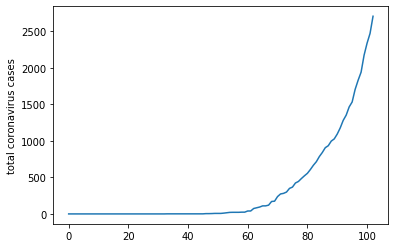

In [11]:
#graphing a curve to see if it's working, which it is
plt.plot(covidData['Afghanistan'])
plt.ylabel('total coronavirus cases')
plt.show()

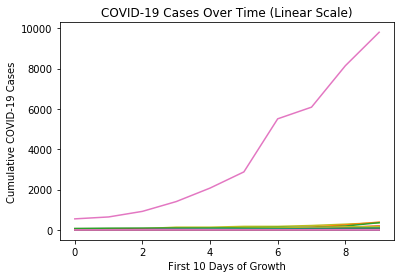

In [27]:
#graphing all curves just to see
plt.plot(Standf)
plt.ylabel('Cumulative COVID-19 Cases')
plt.xlabel('First 10 Days of Growth')
plt.title('COVID-19 Cases Over Time (Linear Scale)')
plt.show()

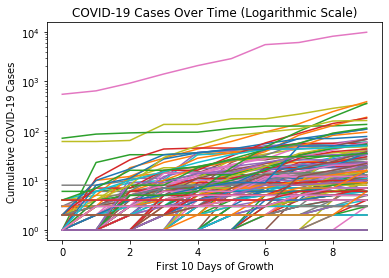

In [29]:
#graphing using log scale just to see
plt.plot(Standf)
plt.ylabel('Cumulative COVID-19 Cases')
plt.xlabel('First 10 Days of Growth')
plt.title('COVID-19 Cases Over Time (Logarithmic Scale)')
plt.yscale('log')
plt.show()

In [39]:
from scipy.optimize import curve_fit

def funcPower(x,a,b):
    return a * np.power(b,x)

In [40]:
#testing
popt, pcov = curve_fit(funcPower, covidData.index, covidData['United Kingdom'])
print(popt)

[835.06371378   1.05603035]


In [41]:
#testing
popt, pcov = curve_fit(funcPower, covidData.index, covidData['US'])
print(popt)

[6.25736692e+03 1.05406430e+00]


In [42]:
#reading csv of global population densities
popDensities = pd.read_csv('countryPopDensities.csv', encoding = 'cp1252')

#the csv contains data from 1960 to 2018, we're only concerned with the 2018 data
recentPopDensities = popDensities[['Country Name', '2018']]

print(recentPopDensities)

     Country Name        2018
0           Aruba  588.027778
1     Afghanistan   56.937760
2          Angola   24.713052
3         Albania  104.612263
4         Andorra  163.842553
..            ...         ...
259        Kosovo         NaN
260   Yemen, Rep.   53.977853
261  South Africa   47.630120
262        Zambia   23.341479
263      Zimbabwe   37.324591

[264 rows x 2 columns]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in less
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in less


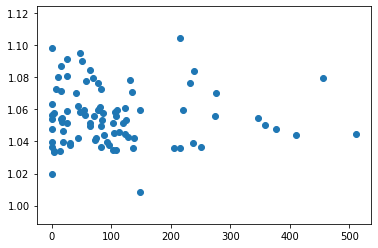

In [43]:
#match up population density data with the COVID-19 data
y = np.zeros(len(covidData.columns), dtype = float)
i = 0

for country in covidData.columns:
    try:
        popt, pcov = curve_fit(funcPower, covidData.index, covidData[country])
        y[i] = popt[1]
        i += 1
    except:
        y[i] = -1
        i += 1


x = np.zeros(len(covidData.columns), dtype = float)

#matching population data with corresponding COVID-19 data indexes
for index, row in recentPopDensities.iterrows():
    j = 0
    for name in covidData.columns:
        if row['Country Name'] == name:
            x[j] = row['2018']
        j += 1

#removing the problematic elements of the list
x = x[y != -1]
y = y[y != -1]

y = y[x < 1000]
x = x[x < 1000]

plt.scatter(x, y)

plt.show()


In [44]:
#linear regression on densities plotted against growth
from sklearn.linear_model import LinearRegression

x = x.reshape((-1,1))

model = LinearRegression()
model.fit(x, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [50]:
r_sq = model.score(x, y)
print('R-value', math.sqrt(r_sq))
print('R-squared value', r_sq)

R-value 0.03360587642249334
R-squared value 0.0011293549301238937


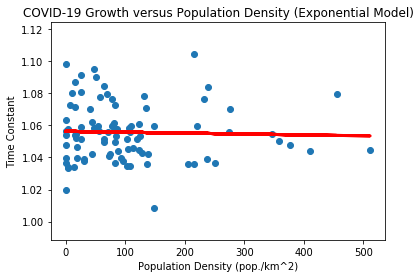

In [48]:
ypred = model.predict(x)

plt.scatter(x, y)
plt.plot(x, ypred, color='red', linewidth=3)
plt.ylabel('Time Constant')
plt.xlabel('Population Density (pop./km^2)')
plt.title('COVID-19 Growth versus Population Density (Exponential Model)')
plt.show()